In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainties
from uncertainties import ufloat, unumpy
from uncertainties.umath import log, sin, radians
from scipy.odr import ODR, Model, RealData
from scipy.optimize import fsolve, curve_fit
from matplotlib.ticker import AutoMinorLocator, LogLocator
from scipy import constants

## Data Loader

In [1]:
def load_data(path):
    np.set_printoptions(suppress=True, precision=10)
    data_list = sorted(glob.glob(path))
    data_np = []
    for i in data_list:
        data = pd.read_csv(i, sep=',')
        data_np.append(data.to_numpy())
    return data_np

In [3]:
path_voltage = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/*.csv'
data1_2, voltage = load_data(path=path_voltage)

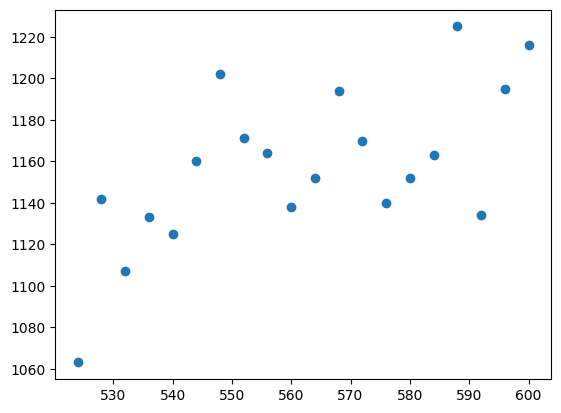

In [8]:
plt.scatter(voltage[:,0][7:], voltage[:,1][7:])

In [9]:
np.mean([min(voltage[:,0][7:]), max(voltage[:,0][7:])])

562.0